In [16]:
import os
from os.path import isdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Loading and Reshaping Data

We'll start again by reading in the data we extracted earlier. We'll train with only the command words, but this time we'll be using the augmented data in addition.

In [2]:
words = os.listdir('../data/train')
command_words = sorted(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence'])


def load_word(fold, word, augmented=False):
    """
    Reads in MFCC data for a single word in a given fold
    Returns tuple of X and y data for that word
    """
    if augmented and word != 'silence' and fold == 'train':
        try:
            X = np.load('../data/{}/{}/mfcc_augmented.npy'.format(fold, word))
        except:
            X = np.load('../data/{}/{}/mfcc.npy'.format(fold, word))
    else:
        X = np.load('../data/{}/{}/mfcc.npy'.format(fold, word))
    y = np.full(shape=X.shape[0],
                fill_value=word if word in command_words else 'unknown')
    return X, y

def get_fold_data(fold, words=words, augmented=False):
    """
    Reads in mfcc data  and labels for entire fold
    fold: 'train', 'validation', or 'test'
    words: list of words to extract
    augmented: boolean value that determines if the augmented data is loaded along with the given data
    """
    
    X_total = np.array([]).reshape(0, 20 , 32)
    y_total = np.array([])
    for word in words:
        X_word, y_word = load_word(fold, word, augmented)
        X_total = np.vstack([X_total, X_word])
        y_total = np.append(y_total, y_word)
        
    return X_total, y_total

X_train, y_train = get_fold_data('train', command_words, augmented=True)
X_val, y_val = get_fold_data('validation', command_words, augmented=True)
X_test, y_test = get_fold_data('test', command_words, augmented=True)

print('Number of training samples: {}'.format(len(X_train)))
print('Number of validation samples: {}'.format(len(X_val)))
print('Number of testing samples: {}'.format(len(X_test)))
print('Shape of each sample: {}'.format(X_train[0].shape))

Number of training samples: 38569
Number of validation samples: 4153
Number of testing samples: 4524
Shape of each sample: (20, 32)


In [3]:
#holds counts of each word for each fold
word_counts = pd.DataFrame()
for fold, y in zip(['train', 'validation', 'test'], [y_train, y_val, y_test]):
    word_counts[fold] = pd.Series(y).value_counts()
word_counts = word_counts.sort_index()
word_counts

,train,validation,test
down,4634,377,406
go,4606,372,402
left,3037,352,412
no,4630,406,405
off,2970,373,402
on,3086,363,396
right,3019,363,396
silence,3300,450,450
stop,3111,350,411
up,2948,350,425


Now that we've loaded in the data, we'll need to follow the same process of reformatting it a little so that we can feed it into our neural networks. For the y values, we'll need to transform the labelled words into one hot encoded integers. We'll also need to reshape the X values so that it can be treated as an image.

In [4]:
def reformat_X(X):
    """
    Reshapes X into an 'image' of depth 1
    """
    X = X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    return X

def reformat_y(y):
    """
    Formats y into one hot encoded integers
    """
    y = LabelEncoder().fit_transform(y)
    y = to_categorical(y)
    return y

X_train_img = reformat_X(X_train)
X_val_img = reformat_X(X_val)
X_test_img = reformat_X(X_test)

y_train_hot = reformat_y(y_train)
y_val_hot = reformat_y(y_val)
y_test_hot = reformat_y(y_test)
    
print('X_train shape: {}'.format(X_train_img.shape))
print('y_train_hot shape: {}'.format(y_train_hot.shape))

X_train shape: (38569, 20, 32, 1)
y_train_hot shape: (38569, 11)


# Convolutional Neural Network

In [7]:
dropout_percentage = np.arange(0, 1, .1)
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
dict(optimizer=optimizer, dropout_percentage=dropout_percentage)

{'dropout_percentage': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'optimizer': ['SGD',
  'RMSprop',
  'Adagrad',
  'Adadelta',
  'Adam',
  'Adamax',
  'Nadam']}

In [8]:
def create_model(optimizer, dropout_percentage):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train_img[0].shape)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(512, kernel_size=(2, 2), activation='relu'))
    model.add(Dropout(dropout_percentage))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_percentage))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=128, verbose=0)
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
dropout_percentage = np.arange(0, 1, .1)
param_grid = dict(optimizer=optimizer,
                  dropout_percentage=dropout_percentage)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_val_img, y_val_hot)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#model.fit(X_train_img, y_train_hot, batch_size=128, epochs=100, verbose=1,
#          validation_data=(X_val_img, y_val_hot), callbacks=[EarlyStopping(patience=3)])

Best: 0.184204 using {'dropout_percentage': 0.2, 'optimizer': 'RMSprop'}
0.023116 (0.017818) with: {'dropout_percentage': 0.0, 'optimizer': 'SGD'}
0.149290 (0.012833) with: {'dropout_percentage': 0.0, 'optimizer': 'RMSprop'}
0.148086 (0.007126) with: {'dropout_percentage': 0.0, 'optimizer': 'Adagrad'}
0.142548 (0.012032) with: {'dropout_percentage': 0.0, 'optimizer': 'Adadelta'}
0.169516 (0.039139) with: {'dropout_percentage': 0.0, 'optimizer': 'Adam'}
0.151216 (0.044865) with: {'dropout_percentage': 0.0, 'optimizer': 'Adamax'}
0.161329 (0.032655) with: {'dropout_percentage': 0.0, 'optimizer': 'Nadam'}
0.018059 (0.025544) with: {'dropout_percentage': 0.1, 'optimizer': 'SGD'}
0.141584 (0.032276) with: {'dropout_percentage': 0.1, 'optimizer': 'RMSprop'}
0.160366 (0.038944) with: {'dropout_percentage': 0.1, 'optimizer': 'Adagrad'}
0.139658 (0.013825) with: {'dropout_percentage': 0.1, 'optimizer': 'Adadelta'}
0.165182 (0.037460) with: {'dropout_percentage': 0.1, 'optimizer': 'Adam'}
0.1714

In [21]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
model = create_model(optimizer='RMSprop', dropout_percentage=0.2)

model.fit(X_train_img, y_train_hot, batch_size=128, epochs=20, verbose=1,
          validation_data=(X_val_img, y_val_hot), callbacks=[checkpoint])

Train on 38569 samples, validate on 4153 samples
Epoch 1/20
38569/38569 [==============================] - 44s 1ms/step - loss: 1.1714 - acc: 0.5823 - val_loss: 0.6465 - val_acc: 0.7782
Epoch 2/20
38569/38569 [==============================] - 12s 317us/step - loss: 0.5632 - acc: 0.8041 - val_loss: 0.3584 - val_acc: 0.8760
Epoch 3/20
38569/38569 [==============================] - 12s 323us/step - loss: 0.4109 - acc: 0.8570 - val_loss: 0.5239 - val_acc: 0.8302
Epoch 4/20
38569/38569 [==============================] - 13s 328us/step - loss: 0.3388 - acc: 0.8820 - val_loss: 0.2423 - val_acc: 0.9222
Epoch 5/20
38569/38569 [==============================] - 13s 333us/step - loss: 0.2887 - acc: 0.8975 - val_loss: 0.2456 - val_acc: 0.9208
Epoch 6/20
38569/38569 [==============================] - 13s 325us/step - loss: 0.2620 - acc: 0.9099 - val_loss: 0.1877 - val_acc: 0.9374
Epoch 7/20
38569/38569 [==============================] - 12s 315us/step - loss: 0.2410 - acc: 0.9149 - val_loss: 0.224

In [22]:
model.load_weights('best_model.h5')
score = model.evaluate(x=X_test_img, y=y_test_hot)

for name, value in zip(model.metrics_names, score):
    print(name, value)

4524/4524 [==============================] - 2s 367us/step
loss 0.20797100506592006
acc 0.9405393457117595


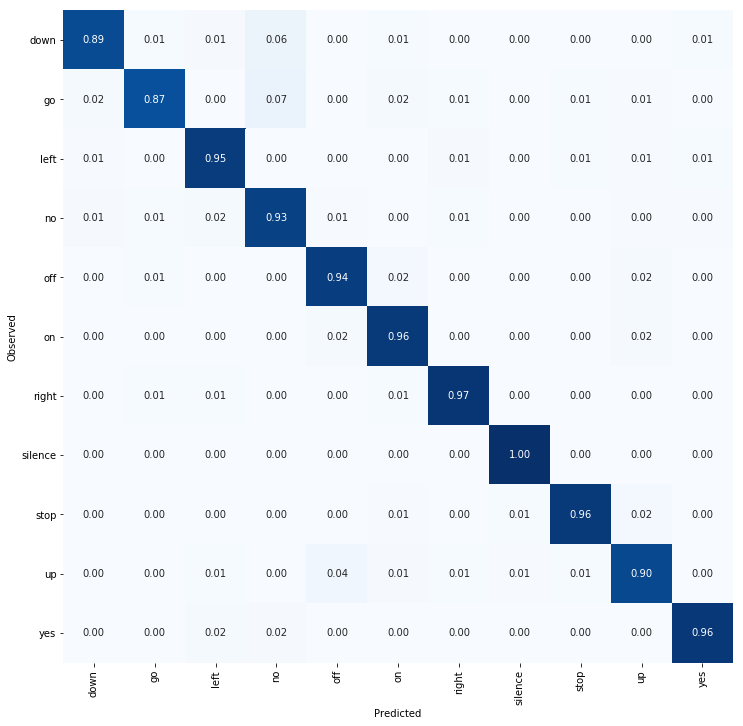

In [25]:
def plot_confusion_matrix(y_obs_labels, y_pred_classes, words=command_words):
    y_pred_labels = np.array([words[y] for y in y_pred_classes])
    conf_matrix = confusion_matrix(y_obs_labels, y_pred_labels)
    conf_matrix_percent = np.divide(conf_matrix.T, conf_matrix.sum(axis=1)).T
    fig, ax = plt.subplots(figsize=(12, 12))    
    sns.heatmap(conf_matrix_percent, cmap='Blues', ax=ax, annot=True, fmt='.2f', cbar=False)
    ax.set_xticklabels(sorted(words), rotation=90)
    ax.set_yticklabels(sorted(words), rotation=0)
    ax.set_ylabel('Observed')
    ax.set_xlabel('Predicted')
    plt.show()
    return conf_matrix_percent  
    
y_pred_val = model.predict_classes(x=X_val_img)
plot_confusion_matrix(y_val, y_pred_val);

# Adding Unknown Detection

In [26]:
X_train_total, y_train_total = get_fold_data('train')
X_val_total, y_val_total = get_fold_data('validation')
X_test_total, y_test_total = get_fold_data('test')

X_img_total = {'train': reformat_X(X_train_total),
              'val': reformat_X(X_val_total),
              'test': reformat_X(X_test_total)}

y_obs_total = {'train': y_train_total,
               'val': y_val_total,
               'test': y_test_total}

y_pred_proba_total = {'train': model.predict(X_img_total['train']),
                      'val': model.predict(X_img_total['val']),
                      'test': model.predict(X_img_total['test'])}


y_pred_classes_total = {'train': model.predict_classes(X_img_total['train']),
                        'val': model.predict_classes(X_img_total['val']),
                        'test': model.predict_classes(X_img_total['test'])}

In [27]:
def create_summary_df(y_obs, y_pred_proba, y_pred_classes):
    labels = command_words + ['unknown']
    df = pd.DataFrame()
    df['y_obs_words'] = y_obs
    df['y_pred_words'] = [labels[class_no] for class_no in y_pred_classes]
    df['max_confidences'] = y_pred_proba.max(axis=1)
    
    def classify_labels(row):
        if row['y_obs_words'] == 'unknown':
            return 'word not in training set'
        elif row['y_obs_words'] == row['y_pred_words']:
            return 'correct'
        else:
            return 'misclassified'
        
    df['labels'] = df.apply(classify_labels, axis=1)
    df['is_correct'] = (df['labels']=='correct')
    return df


def plot_hist(df, ax, color, ylabel, xlabel=False, title=False):
        hist = df[['labels', 'max_confidences']].hist(by='labels', color=color, ax=ax, bins=20)
        hist[0].set_ylabel(ylabel)
        for ax in hist:
            ax.set_xticks(np.linspace(0, 1, num=21))
        if not title:
            for ax in hist:
                ax.set_title('')
        if xlabel:
            for ax in hist:
                ax.set_xlabel('maximum classification confidence')          
        return hist
    
    
def plot_hist_grid(y_obs, y_pred_proba, y_pred_classes, title=''):
    train_df = create_summary_df(y_obs['train'], y_pred_proba['train'], y_pred_classes['train'])
    val_df = create_summary_df(y_obs['val'], y_pred_proba['val'], y_pred_classes['val'])
    
    fig, ax = plt.subplots(2, 3, figsize=(15 , 8))
    plot_hist(train_df, color='C0', title=True, ylabel='train samples', ax=ax[0])
    plot_hist(val_df, color='C1', ylabel='validation samples', xlabel=True, ax=ax[1])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title)
    return ax


def plot_roc_curve(df, ax):
    fpr, tpr, _ = roc_curve(df['is_correct'], df['max_confidences'])

    ax.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2,
                 color='b')

    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    ax.set_aspect('equal')
    return ax;

def modify_pred_classes(y_pred_proba, y_pred_classes, thresh=.9):
    probs = y_pred_proba.max(axis=1)
    is_unknown = probs < thresh
    y_pred_modified = y_pred_classes.copy()
    y_pred_modified[is_unknown] = 11
    return y_pred_modified
  
    
def score_with_unknown(y_obs, y_pred_classes, words=command_words+['unknown']):
    pred_words = np.array([words[y] for y in y_pred_classes])
    accuracy = (pred_words == y_obs).sum()/y_obs.size
    return accuracy

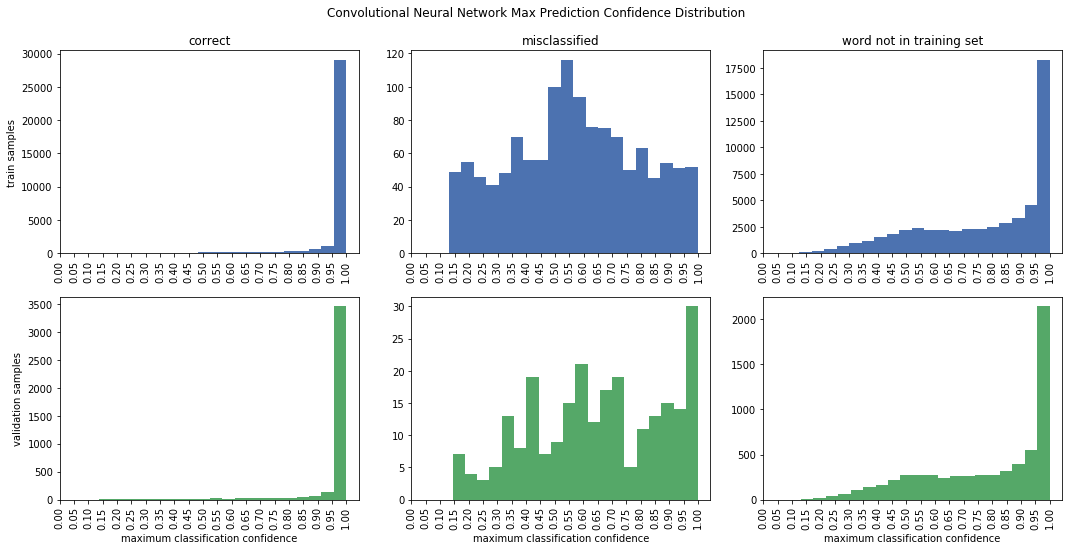

In [28]:
plot_hist_grid(y_obs_total, y_pred_proba_total, y_pred_classes_total,
               title='Convolutional Neural Network Max Prediction Confidence Distribution');

train accuracy: 0.7299275041693611
val accuracy: 0.7212156073243218
test accuracy: 0.7190746398952422


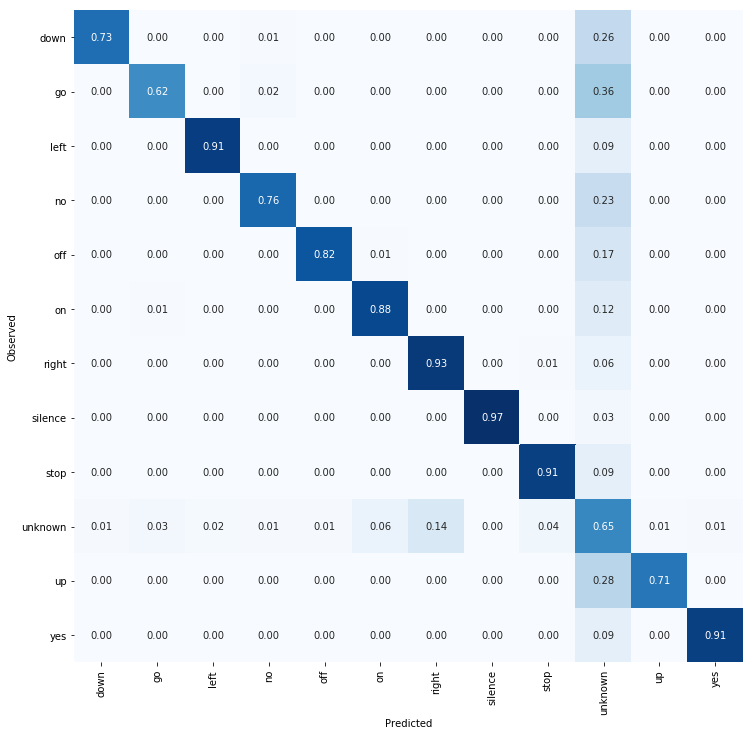

In [29]:
y_pred_modified = {
    fold: modify_pred_classes(y_pred_proba_total[fold],
                              y_pred_classes_total[fold], thresh=.95)
    for fold in ['train', 'val', 'test']
}


for fold in ['train', 'val', 'test']:
    print(fold, 'accuracy:', score_with_unknown(y_obs_total[fold], y_pred_modified[fold]))
    
plot_confusion_matrix(y_obs_total['test'], y_pred_modified['test'], words=command_words+['unknown']);